<a href="https://colab.research.google.com/github/ishaaaa12/Sentiment-Analysis-Classifier-using-DistilBERT-and-Vader/blob/main/sentimentAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install vaderSentiment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 8.5 MB/s eta 0:00:00


In [2]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from transformers import DistilBertModel, DistilBertTokenizerFast
from torch.utils.data import DataLoader
from torch.optim import AdamW
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

In [3]:
!wget https://raw.githubusercontent.com/kyuz0/llm-chronicles/main/datasets/restaurant_reviews.csv

--2025-06-15 06:50:31--  https://raw.githubusercontent.com/kyuz0/llm-chronicles/main/datasets/restaurant_reviews.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2861025 (2.7M) [text/plain]
Saving to: ‘restaurant_reviews.csv’

restaurant_reviews. 100%[===================>]   2.73M  --.-KB/s    in 0.01s   

2025-06-15 06:50:32 (201 MB/s) - ‘restaurant_reviews.csv’ saved [2861025/2861025]



In [4]:
df = pd.read_csv('restaurant_reviews.csv')
display(df.head())

,Review,Rating
0,The ambience was good food was quite good . ha...,positive
1,Ambience is too good for a pleasant evening. S...,positive
2,A must try.. great food great ambience. Thnx f...,positive
3,Soumen das and Arun was a great guy. Only beca...,positive
4,Food is good.we ordered Kodi drumsticks and ba...,positive


In [5]:
# Map sentiments to numerical labels
sentiment_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}
df['Rating'] = df['Rating'].map(sentiment_mapping)

In [6]:
df.head()# Display statistics about the dataset
print("\nDataset Statistics:")
print(df['Rating'].value_counts())


Dataset Statistics:
Rating
2    6331
0    2428
1    1192
Name: count, dtype: int64


In [7]:
class ReviewDataset(Dataset):
    def __init__(self, csv_file, tokenizer, max_length):
        self.dataset = pd.read_csv(csv_file)
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.label_dict = {'negative': 0, 'neutral': 1, 'positive': 2}
        self.vader_analyzer = SentimentIntensityAnalyzer()

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        review_text = self.dataset.iloc[idx, 0]  # First column: Review
        sentiment = self.dataset.iloc[idx, 1]    # Second column: Rating
        labels = self.label_dict[sentiment]

        # Tokenize the review text
        encoding = self.tokenizer.encode_plus(
            review_text,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )

        # Compute VADER sentiment scores
        vader_scores = self.vader_analyzer.polarity_scores(review_text)
        vader_features = torch.tensor([vader_scores['compound']], dtype=torch.float)  # Shape: [1]

        return {
            'review_text': review_text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(labels, dtype=torch.long),
            'vader_features': vader_features
        }

In [8]:
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
review_dataset = ReviewDataset('restaurant_reviews.csv', tokenizer, 512)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [9]:
review_dataset[0]

{'review_text': 'The ambience was good food was quite good . had Saturday lunch which was cost effective . Good place for a sate brunch. One can also chill with friends and or parents. Waiter Soumen Das was really courteous and helpful.',
 'input_ids': tensor([  101,  1996,  2572, 11283,  5897,  2001,  2204,  2833,  2001,  3243,
          2204,  1012,  2018,  5095,  6265,  2029,  2001,  3465,  4621,  1012,
          2204,  2173,  2005,  1037,  2938,  2063,  7987,  4609,  2818,  1012,
          2028,  2064,  2036, 10720,  2007,  2814,  1998,  2030,  3008,  1012,
         15610,  2061, 27417,  8695,  2001,  2428,  2457, 14769,  1998, 14044,
          1012,   102,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0, 

In [10]:
tokenizer.decode(review_dataset[0]['input_ids'])

'[CLS] the ambience was good food was quite good. had saturday lunch which was cost effective. good place for a sate brunch. one can also chill with friends and or parents. waiter soumen das was really courteous and helpful. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [

In [11]:
# Split dataset into training and validation
train_size = int(0.8 * len(review_dataset))
val_size = len(review_dataset) - train_size
train_dataset, test_dataset = random_split(review_dataset, [train_size, val_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

In [12]:
# Show number of batches
len(train_loader), len(test_loader)

(498, 125)

SENTIMENT ANALYSIS USING ONLY VADER MODEL

In [24]:
# VADER baseline evaluation
def vader_predict_sentiment(review_text, analyzer):
    scores = analyzer.polarity_scores(review_text)
    compound = scores['compound']
    if compound >= 0.05:
        return 2  # Positive
    elif compound <= -0.05:
        return 0  # Negative
    else:
        return 1  # Neutral

vader_analyzer = SentimentIntensityAnalyzer()
vader_preds = []
vader_labels = []
for i in test_dataset.indices:
    review_text = review_dataset[i]['review_text']
    true_label = review_dataset[i]['labels'].item()
    pred_label = vader_predict_sentiment(review_text, vader_analyzer)
    vader_preds.append(pred_label)
    vader_labels.append(true_label)

In [25]:
vader_accuracy = np.mean(np.array(vader_preds) == np.array(vader_labels))
print(f"VADER Baseline Accuracy: {vader_accuracy:.4f}")

VADER Baseline Accuracy: 0.7654


Finetuning a DistilBERT model

In [13]:
class DistilBertOnlyForSequenceClassification(nn.Module):
    def __init__(self, num_labels=3):
        super(DistilBertOnlyForSequenceClassification, self).__init__()
        self.distilbert = DistilBertModel.from_pretrained('distilbert-base-uncased')
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(768, num_labels)

    def forward(self, input_ids, attention_mask):
        distilbert_output = self.distilbert(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = distilbert_output[0]
        pooled_output = hidden_state[:, 0]
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        return logits

In [15]:
# Initialize model and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
distilbert_only_model = DistilBertOnlyForSequenceClassification().to(device)
optimizer = AdamW(distilbert_only_model.parameters(), lr=5e-5)

In [16]:
# Training loop
distilbert_only_model.train()
for epoch in range(10):
    epoch_loss = 0
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        logits = distilbert_only_model(input_ids=input_ids, attention_mask=attention_mask)
        loss = nn.CrossEntropyLoss()(logits, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    print(f"DistilBERT Only - Epoch {epoch + 1}, Average Loss: {epoch_loss / len(train_loader):.4f}")

DistilBERT Only - Epoch 1, Average Loss: 0.4192
DistilBERT Only - Epoch 2, Average Loss: 0.2798
DistilBERT Only - Epoch 3, Average Loss: 0.1856
DistilBERT Only - Epoch 4, Average Loss: 0.1130
DistilBERT Only - Epoch 5, Average Loss: 0.0812
DistilBERT Only - Epoch 6, Average Loss: 0.0576
DistilBERT Only - Epoch 7, Average Loss: 0.0514
DistilBERT Only - Epoch 8, Average Loss: 0.0426
DistilBERT Only - Epoch 9, Average Loss: 0.0453
DistilBERT Only - Epoch 10, Average Loss: 0.0333


In [17]:
distilbert_only_model.eval()
distilbert_only_preds = []
distilbert_only_labels = []
for batch in test_loader:
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['labels'].to(device)

    with torch.inference_mode():
        logits = distilbert_only_model(input_ids=input_ids, attention_mask=attention_mask)
    predictions = torch.argmax(logits, dim=1)
    distilbert_only_preds.extend(predictions.cpu().numpy())
    distilbert_only_labels.extend(labels.cpu().numpy())

distilbert_only_accuracy = np.mean(np.array(distilbert_only_preds) == np.array(distilbert_only_labels))
print(f"DistilBERT Only Accuracy: {distilbert_only_accuracy:.4f}")

DistilBERT Only Accuracy: 0.8232


COMBINING DISTILBERT AND VADER

In [18]:
class CustomDistilBertForSequenceClassification(nn.Module):
    def __init__(self, num_labels=3, vader_feature_dim=1):
        super(CustomDistilBertForSequenceClassification, self).__init__()
        self.distilbert = DistilBertModel.from_pretrained('distilbert-base-uncased')
        self.pre_classifier = nn.Linear(768 + vader_feature_dim, 768)
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(768, num_labels)

    def forward(self, input_ids, attention_mask, vader_features):
        distilbert_output = self.distilbert(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = distilbert_output[0]  # (batch_size, sequence_length, hidden_size)
        pooled_output = hidden_state[:, 0]   # [CLS] token
        combined_output = torch.cat((pooled_output, vader_features), dim=1)
        combined_output = self.pre_classifier(combined_output)
        combined_output = nn.ReLU()(combined_output)
        combined_output = self.dropout(combined_output)
        logits = self.classifier(combined_output)
        return logits

In [19]:
# Initialize model and move to device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CustomDistilBertForSequenceClassification(vader_feature_dim=1)
model.to(device)

CustomDistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=F

In [20]:
# Initialize optimizer
optimizer = AdamW(model.parameters(), lr=5e-5)

In [21]:
# Training loop
model.train()
for epoch in range(10):
    for i, batch in enumerate(train_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        vader_features = batch['vader_features'].to(device)

        optimizer.zero_grad()
        logits = model(input_ids=input_ids, attention_mask=attention_mask, vader_features=vader_features)
        loss = nn.CrossEntropyLoss()(logits, labels)
        loss.backward()
        optimizer.step()

        if (i + 1) % 100 == 0:
            print(f"Epoch {epoch + 1}, Batch {i + 1}, Loss: {loss.item():.4f}")


Epoch 1, Batch 100, Loss: 0.3963
Epoch 1, Batch 200, Loss: 0.6818
Epoch 1, Batch 300, Loss: 0.4120
Epoch 1, Batch 400, Loss: 0.5230
Epoch 2, Batch 100, Loss: 0.3791
Epoch 2, Batch 200, Loss: 0.5123
Epoch 2, Batch 300, Loss: 0.4709
Epoch 2, Batch 400, Loss: 0.4739
Epoch 3, Batch 100, Loss: 0.3139
Epoch 3, Batch 200, Loss: 0.0344
Epoch 3, Batch 300, Loss: 0.0550
Epoch 3, Batch 400, Loss: 0.1094
Epoch 4, Batch 100, Loss: 0.3512
Epoch 4, Batch 200, Loss: 0.0459
Epoch 4, Batch 300, Loss: 0.0184
Epoch 4, Batch 400, Loss: 0.1578
Epoch 5, Batch 100, Loss: 0.0133
Epoch 5, Batch 200, Loss: 0.0262
Epoch 5, Batch 300, Loss: 0.0704
Epoch 5, Batch 400, Loss: 0.1725
Epoch 6, Batch 100, Loss: 0.0240
Epoch 6, Batch 200, Loss: 0.1346
Epoch 6, Batch 300, Loss: 0.0784
Epoch 6, Batch 400, Loss: 0.0031
Epoch 7, Batch 100, Loss: 0.3691
Epoch 7, Batch 200, Loss: 0.1506
Epoch 7, Batch 300, Loss: 0.0194
Epoch 7, Batch 400, Loss: 0.0780
Epoch 8, Batch 100, Loss: 0.0070
Epoch 8, Batch 200, Loss: 0.0051
Epoch 8, B

In [22]:
# Evaluation loop with predictions collection
model.eval()
all_preds = []
all_labels = []
for batch in test_loader:
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['labels'].to(device)
    vader_features = batch['vader_features'].to(device)

    with torch.inference_mode():
        logits = model(input_ids=input_ids, attention_mask=attention_mask, vader_features=vader_features)
    predictions = torch.argmax(logits, dim=1)
    all_preds.extend(predictions.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())

In [23]:
# Calculate accuracy
accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
print(f'Test Accuracy: {accuracy:.4f}')

Test Accuracy: 0.8543


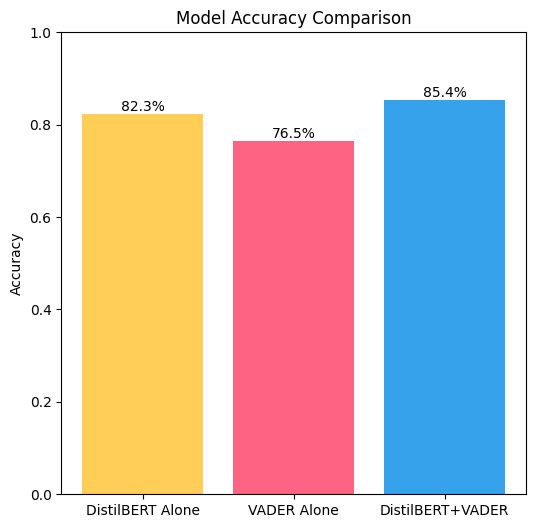

In [28]:
plt.figure(figsize=(6, 6))
bars=plt.bar(['DistilBERT Alone', 'VADER Alone', 'DistilBERT+VADER'],
        [distilbert_only_accuracy, vader_accuracy, accuracy],
        color=['#FFCE56', '#FF6384', '#36A2EB'])
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height*100:.1f}%',
             ha='center', va='bottom', fontsize=10)
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.ylim(0, 1)
plt.show()

EVALUATION OF HYBRID MODEL

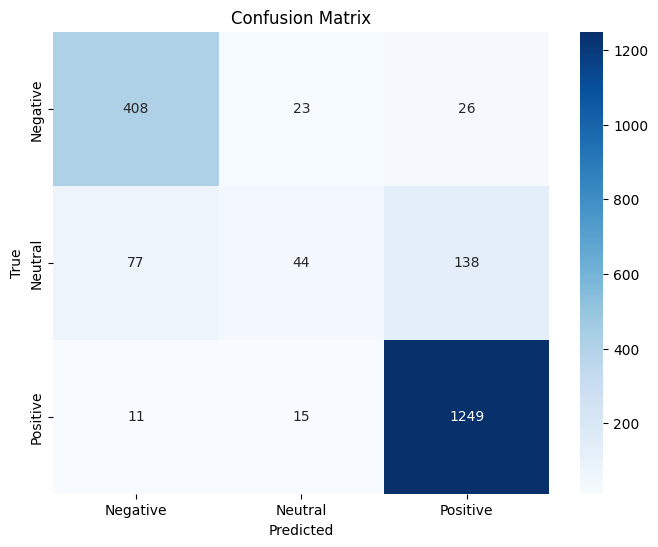

In [29]:
# Generate confusion matrix
cm = confusion_matrix(all_labels, all_preds)
labels = ['Negative', 'Neutral', 'Positive']

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [30]:
# Generate classification report
report = classification_report(all_labels, all_preds, target_names=labels, output_dict=True)
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=labels))


Classification Report:
              precision    recall  f1-score   support

    Negative       0.82      0.89      0.86       457
     Neutral       0.54      0.17      0.26       259
    Positive       0.88      0.98      0.93      1275

    accuracy                           0.85      1991
   macro avg       0.75      0.68      0.68      1991
weighted avg       0.82      0.85      0.83      1991



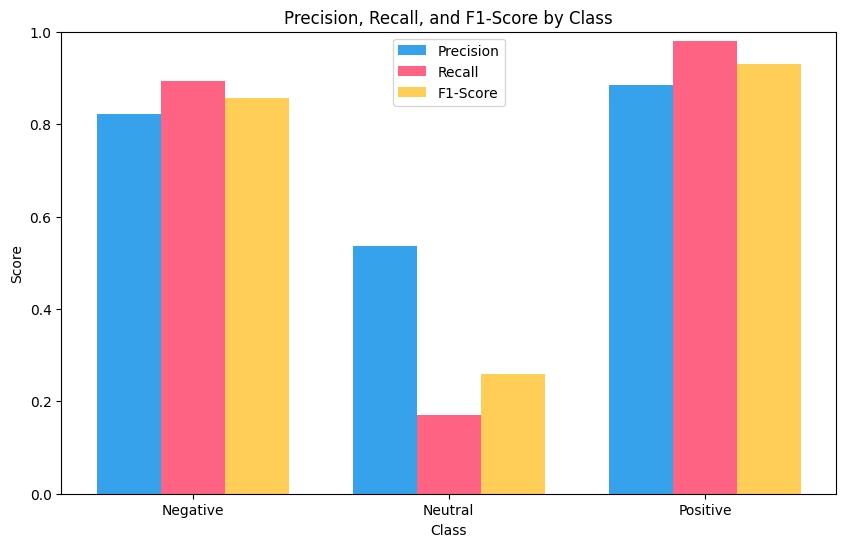

In [31]:
# Plot precision, recall, F1-score
metrics = ['precision', 'recall', 'f1-score']
classes = ['Negative', 'Neutral', 'Positive']
scores = {metric: [report[cls][metric] for cls in classes] for metric in metrics}

plt.figure(figsize=(10, 6))
x = np.arange(len(classes))
width = 0.25

plt.bar(x - width, scores['precision'], width, label='Precision', color='#36A2EB')
plt.bar(x, scores['recall'], width, label='Recall', color='#FF6384')
plt.bar(x + width, scores['f1-score'], width, label='F1-Score', color='#FFCE56')
plt.xlabel('Class')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1-Score by Class')
plt.xticks(x, classes)
plt.legend()
plt.ylim(0, 1)
plt.show()

In [32]:
def predict_sentiment(review_text, model, tokenizer, max_length=512):
    """
    Predicts the sentiment of a given review text.

    Args:
        review_text (str): The review text to analyze.
        model (torch.nn.Module): The fine-tuned sentiment analysis model.
        tokenizer (PreTrainedTokenizer): The tokenizer for encoding the text.
        max_length (int): The maximum sequence length for the model.

    Returns:
        sentiment (str): The predicted sentiment label ('negative', 'neutral', 'positive').
    """
    model.eval()
    vader_analyzer = SentimentIntensityAnalyzer()

    # Tokenize the input text
    encoding = tokenizer.encode_plus(
        review_text,
        add_special_tokens=True,
        max_length=max_length,
        return_token_type_ids=False,
        padding='max_length',
        return_attention_mask=True,
        return_tensors='pt',
        truncation=True
    )

    # Compute VADER scores
    vader_scores = vader_analyzer.polarity_scores(review_text)
    vader_features = torch.tensor([[vader_scores['compound']]], dtype=torch.float)  # Shape: [1, 1]

    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    vader_features = vader_features.to(device)

    with torch.inference_mode():
        logits = model(input_ids=input_ids, attention_mask=attention_mask, vader_features=vader_features)
    prediction = torch.argmax(logits, dim=1).item()

    label_dict = {0: 'negative', 1: 'neutral', 2: 'positive'}
    sentiment = label_dict[prediction]

    return sentiment

In [33]:
# Test predictions
review_1 = "We ordered from Papa Johns a so-called pizza... what to say? I'd rather eat a piece of dry cardboard, calling this pizza is an insult to Italians!"
review_2 = "I guess PizzaHut is decent but far from the Italian pizza. This is not going to blow you away, but still quite ok in the end."
review_3 = "Gino's pizza is what authentical Neapolian pizza tastes like, highly recommended."

print("\nSentiment Predictions:")
print(f"Review 1: {predict_sentiment(review_1, model, tokenizer)}")
print(f"Review 2: {predict_sentiment(review_2, model, tokenizer)}")
print(f"Review 3: {predict_sentiment(review_3, model, tokenizer)}")


Sentiment Predictions:
Review 1: negative
Review 2: neutral
Review 3: positive
